In [122]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report

import ipywidgets as widgets

sns.set_style('darkgrid')

In [123]:
df = pd.read_csv("train.csv")
df.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [124]:
print(df.columns)

Index(['Unnamed: 0', 'id', 'Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction'],
      dtype='object')


In [125]:
# usuwanie niepotrzenym kolumn

df = df.drop(['Unnamed: 0', 'id'], axis =1)

In [126]:
# sprawdzanie typów danych, brakujących wartości

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             103904 non-null  object 
 1   Customer Type                      103904 non-null  object 
 2   Age                                103904 non-null  int64  
 3   Type of Travel                     103904 non-null  object 
 4   Class                              103904 non-null  object 
 5   Flight Distance                    103904 non-null  int64  
 6   Inflight wifi service              103904 non-null  int64  
 7   Departure/Arrival time convenient  103904 non-null  int64  
 8   Ease of Online booking             103904 non-null  int64  
 9   Gate location                      103904 non-null  int64  
 10  Food and drink                     103904 non-null  int64  
 11  Online boarding                    1039

In [127]:
df.isnull().sum()

Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction                           0
dtype: int64

<AxesSubplot:>

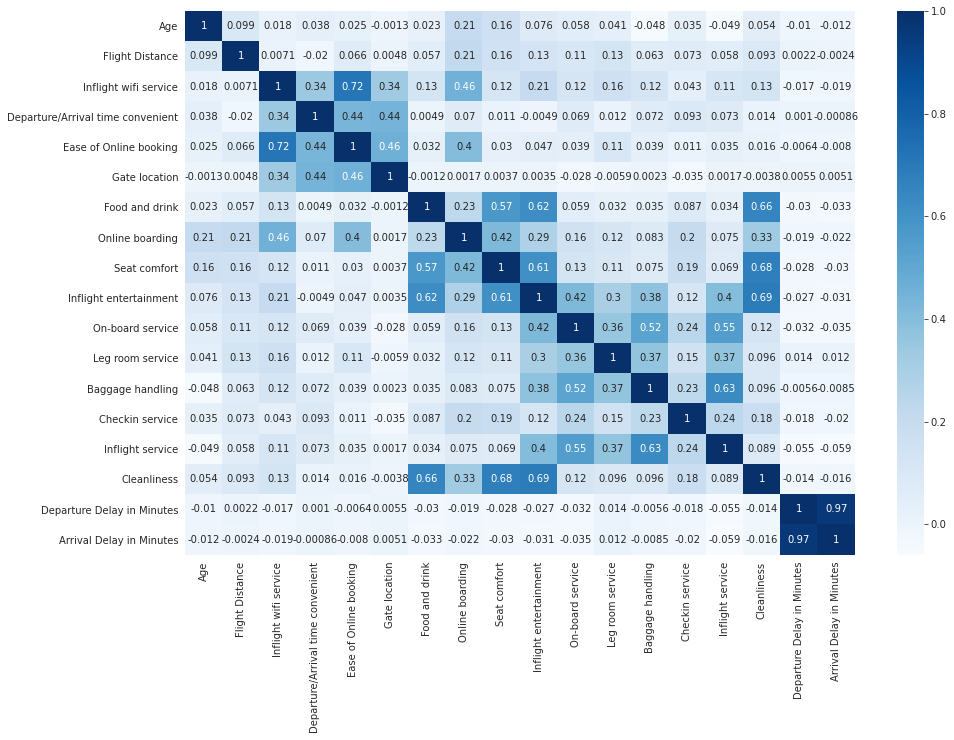

In [128]:
# sprawdzenie korelacji pomiędzy poszczególnymi zmiennymi 

plt.figure(figsize=(15,10))
sns.heatmap(df.loc[:,df.columns!='satisfaction'].corr(), annot=True, cmap = 'Blues')

In [129]:
# usuwanie kolumny arrival delay in minutes silnie skorelowanej z departure delay, w której nie ma Nan

data = df.drop(['Arrival Delay in Minutes'], axis =1)
data.isnull().sum()

Gender                               0
Customer Type                        0
Age                                  0
Type of Travel                       0
Class                                0
Flight Distance                      0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
Cleanliness                          0
Departure Delay in Minutes           0
satisfaction                         0
dtype: int64

In [130]:
num_columns = ["Age" , "Flight Distance" ,"Departure Delay in Minutes"]
cat_columns = list(set(data.columns).difference(num_columns))
print(num_columns,cat_columns)

['Age', 'Flight Distance', 'Departure Delay in Minutes'] ['On-board service', 'Checkin service', 'Type of Travel', 'satisfaction', 'Inflight entertainment', 'Leg room service', 'Departure/Arrival time convenient', 'Online boarding', 'Ease of Online booking', 'Seat comfort', 'Customer Type', 'Inflight service', 'Inflight wifi service', 'Gender', 'Gate location', 'Baggage handling', 'Food and drink', 'Class', 'Cleanliness']


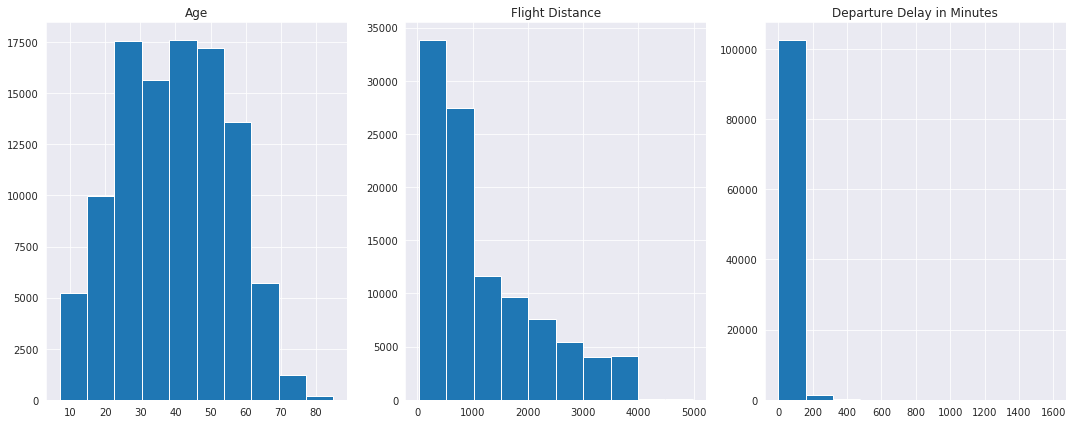

In [131]:
# histogramy zmiennych numerycznych 

fig, axs = plt.subplots(1,3, figsize=(15, 6),tight_layout=True)
fig.subplots_adjust()

axs = axs.ravel()

for i,column in enumerate(num_columns):
    axs[i].hist(data[column])
    axs[i].set_title(column)

In [132]:
data[num_columns].describe()

,Age,Flight Distance,Departure Delay in Minutes
count,103904.000000,103904.000000,103904.000000
mean,39.379706,1189.448375,14.815618
std,15.114964,997.147281,38.230901
min,7.000000,31.000000,0.000000
25%,27.000000,414.000000,0.000000
50%,40.000000,843.000000,0.000000
75%,51.000000,1743.000000,12.000000
max,85.000000,4983.000000,1592.000000


In [133]:
# zamiana targetu na binarny 
# 1 - satisfied
# 0 - neural or dissatisfied 

data['satisfaction'] = data['satisfaction'].apply(lambda x: np.where(x=='satisfied', 1, 0))
data.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,...,5,5,4,3,4,4,5,5,25,0
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,...,1,1,1,5,3,1,4,1,1,0
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,...,5,5,4,3,4,4,4,5,0,1
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,...,2,2,2,5,3,1,4,2,11,0
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,...,5,3,3,4,4,3,3,3,0,1


In [134]:
# one hot encoding zmiennych kategorycznych

data_ohe = pd.get_dummies(data, columns = ['Gender', 'Customer Type','Type of Travel', 'Class'])
data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 27 columns):
 #   Column                             Non-Null Count   Dtype
---  ------                             --------------   -----
 0   Age                                103904 non-null  int64
 1   Flight Distance                    103904 non-null  int64
 2   Inflight wifi service              103904 non-null  int64
 3   Departure/Arrival time convenient  103904 non-null  int64
 4   Ease of Online booking             103904 non-null  int64
 5   Gate location                      103904 non-null  int64
 6   Food and drink                     103904 non-null  int64
 7   Online boarding                    103904 non-null  int64
 8   Seat comfort                       103904 non-null  int64
 9   Inflight entertainment             103904 non-null  int64
 10  On-board service                   103904 non-null  int64
 11  Leg room service                   103904 non-null  int64
 12  Ba

<AxesSubplot:xlabel='Departure Delay_binary', ylabel='count'>

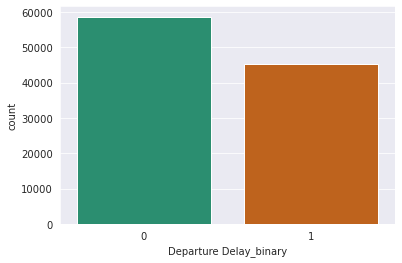

In [135]:
# dodanie kolumny departure delay binarnej 

data_ohe['Departure Delay_binary'] = data_ohe['Departure Delay in Minutes'].apply(lambda x: np.where(x>0, 1, 0))


# sprawdzenie stosunku lotów opóźnionych (1) do nieopóźnionych (0)

sns.countplot(x='Departure Delay_binary', data=data_ohe, palette='Dark2')

In [136]:
data_clear = data_ohe.drop(['Departure Delay in Minutes'], axis =1)
data_clear.head()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,Gender_Female,Gender_Male,Customer Type_Loyal Customer,Customer Type_disloyal Customer,Type of Travel_Business travel,Type of Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus,Departure Delay_binary
0,13,460,3,4,3,1,5,3,5,5,...,0,1,1,0,0,1,0,0,1,1
1,25,235,3,2,3,3,1,3,1,1,...,0,1,0,1,1,0,1,0,0,1
2,26,1142,2,2,2,2,5,5,5,5,...,1,0,1,0,1,0,1,0,0,0
3,25,562,2,5,5,5,2,2,2,2,...,1,0,1,0,1,0,1,0,0,1
4,61,214,3,3,3,3,4,5,5,3,...,0,1,1,0,1,0,1,0,0,0


In [137]:
# ustanowienie X i y, podział zbioru na treningowy i testowy

X = data_clear.drop(['satisfaction'], axis=1)
y = data_clear["satisfaction"]

print(X.shape) #26 kolumn, 103904 wiersze (dane)
print(y.shape) # 103904 wiersze (target)

(103904, 26)
(103904,)


## xgBoost model

In [138]:
data_dm = xgb.DMatrix(data=X.values, label=y)

In [139]:
# dobieranie learning rate 

learning_rates = [0.01, 0.05, 0.1, 0.3, 0.5, 0.8]
cv_results = []

for rate in learning_rates:
    params = {
        "objective": "reg:logistic", 
        "max_depth": 4,
        "booster": "gbtree",
        "learning_rate": rate  
    }

    cv_results.append(xgb.cv(
        dtrain=data_dm, 
        params=params, 
        nfold=4, 
        num_boost_round=200, metrics=["error", "auc"], as_pandas=True))

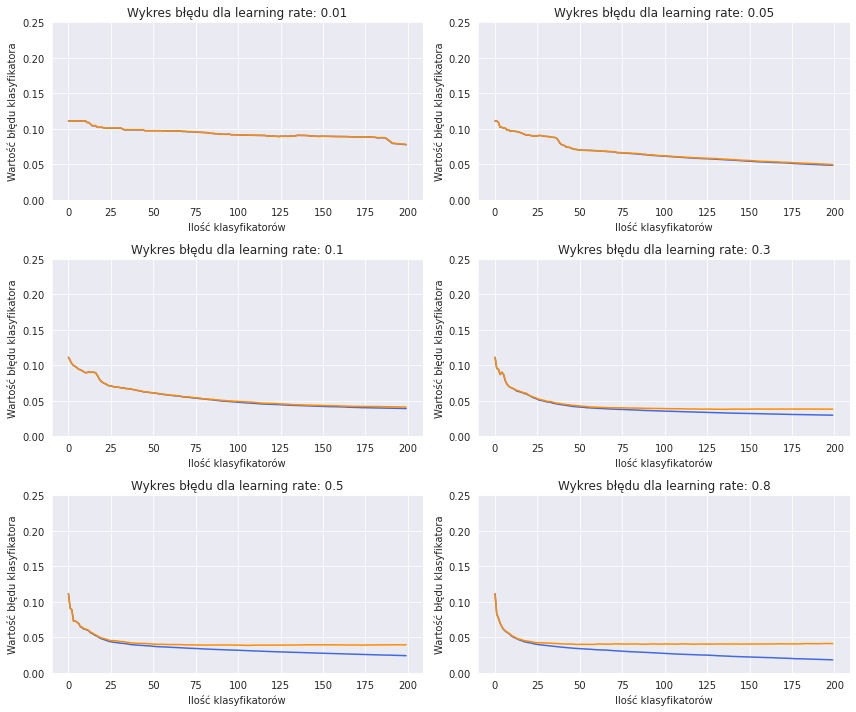

In [140]:
fig, axs = plt.subplots(3,2, figsize=(12, 10),tight_layout=True)
fig.subplots_adjust()

axs = axs.ravel()

for i, data_frame in enumerate(cv_results):
    axs[i].plot(data_frame["train-error-mean"], color="royalblue")
    axs[i].plot(data_frame["test-error-mean"], color="darkorange")
    axs[i].set_ybound(0.00,0.25)
    axs[i].set_ylabel("Wartość błędu klasyfikatora")
    axs[i].set_xlabel("Ilość klasyfikatorów")
    axs[i].set_title(f"Wykres błędu dla learning rate: {learning_rates[i]}")

In [141]:
# podział danych treningowych na treningowe i walidacyjne (testowe)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (83123, 26)
X_test shape:  (20781, 26)
y_train shape:  (83123,)
y_test shape:  (20781,)


In [142]:
# tworzenie finalnego klasyfikatora na podstawie wykresów błędów 

classifier = xgb.XGBClassifier(objective="reg:logistic", max_depth=4, learning_rate=0.5, n_estimators=25)

In [143]:
# trening i ewaluacja

classifier.fit(X_train, y_train)

/home/karolina/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=25, n_jobs=8, num_parallel_tree=1,
              objective='reg:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [144]:
y_pred_train = classifier.predict(X_train)
y_pred_test = classifier.predict(X_test)

acc_train = round(accuracy_score(y_train, y_pred_train),3)
acc_test = round(accuracy_score(y_test, y_pred_test),3)

print(f"Accuracy dla zbioru treningowego: {acc_train}\nAccuracy dla zbioru testowego: {acc_test}")

Accuracy dla zbioru treningowego: 0.957
Accuracy dla zbioru testowego: 0.954


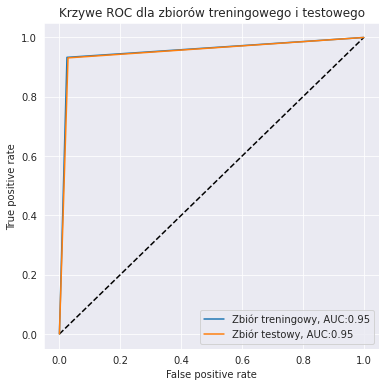

In [145]:
fpr1 , tpr1, thresholds1 = roc_curve(y_train, y_pred_train)
fpr2 , tpr2, thresholds2 = roc_curve(y_test, y_pred_test)

auc1 = round(roc_auc_score(y_train, y_pred_train),2)
auc2 = round(roc_auc_score(y_test, y_pred_test),2)

plt.figure(figsize=(6,6))
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= f"Zbiór treningowy, AUC:{auc1}")
plt.plot(fpr2, tpr2, label= f"Zbiór testowy, AUC:{auc2}")
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title('Krzywe ROC dla zbiorów treningowego i testowego')
plt.show()

In [146]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     11834
           1       0.96      0.93      0.95      8947

    accuracy                           0.95     20781
   macro avg       0.96      0.95      0.95     20781
weighted avg       0.95      0.95      0.95     20781



<AxesSubplot:>

<Figure size 1080x720 with 0 Axes>

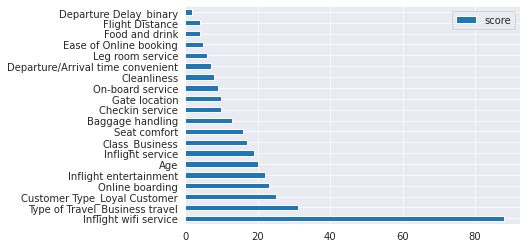

In [147]:
# wyciąganie feature importance z modelu 

feature_important = classifier.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data_importance = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)

plt.figure(figsize=(15,10))
data_importance.plot(kind='barh')

# Regresja logistyczna 

In [148]:
# utworzenie modelu 

LogReg = LogisticRegression(max_iter=1000)

In [149]:
# dopasowanie modelu 

LogReg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [150]:
y_pred_train_logreg = LogReg.predict(X_train)
y_pred_test_logreg = LogReg.predict(X_test)

acc_train_logreg = round(accuracy_score(y_train, y_pred_train_logreg),3)
acc_test_logreg = round(accuracy_score(y_test, y_pred_test_logreg),3)

print(f"Accuracy dla zbioru treningowego: {acc_train_logreg}\nAccuracy dla zbioru testowego: {acc_test_logreg}")

Accuracy dla zbioru treningowego: 0.875
Accuracy dla zbioru testowego: 0.873


In [151]:
print(classification_report(y_test, y_pred_test_logreg))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89     11834
           1       0.86      0.83      0.85      8947

    accuracy                           0.87     20781
   macro avg       0.87      0.87      0.87     20781
weighted avg       0.87      0.87      0.87     20781



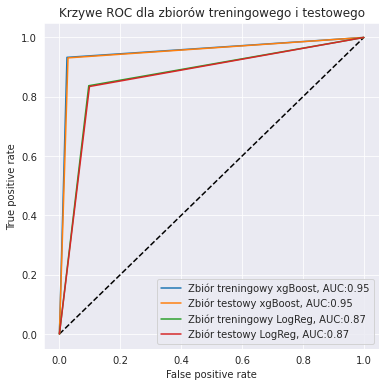

In [152]:
fpr1 , tpr1, thresholds1 = roc_curve(y_train, y_pred_train)
fpr2 , tpr2, thresholds2 = roc_curve(y_test, y_pred_test)
fpr3 , tpr3, thresholds3 = roc_curve(y_train, y_pred_train_logreg)
fpr4 , tpr4, thresholds4 = roc_curve(y_test, y_pred_test_logreg)

auc1 = round(roc_auc_score(y_train, y_pred_train),2)
auc2 = round(roc_auc_score(y_test, y_pred_test),2)
auc3 = round(roc_auc_score(y_train, y_pred_train_logreg),2)
auc4 =round(roc_auc_score(y_test, y_pred_test_logreg),2)

plt.figure(figsize=(6,6))
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= f"Zbiór treningowy xgBoost, AUC:{auc1}")
plt.plot(fpr2, tpr2, label= f"Zbiór testowy xgBoost, AUC:{auc2}")
plt.plot(fpr3 , tpr3, label= f"Zbiór treningowy LogReg, AUC:{auc3}")
plt.plot(fpr4 , tpr4, label= f"Zbiór testowy LogReg, AUC:{auc4}")
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title('Krzywe ROC dla zbiorów treningowego i testowego')
plt.show()

W przypadku tego zbioru danych model xgBoost radzi sobie zdecydowanie lepiej niż regresja logistyczna, ale zdecydowanie dłużej się przelicza. 

In [153]:
# widget z listą serwisów, na które mamy wpływ oraz klasą lotu 

services = ['Inflight wifi service','Food and drink', 'Online boarding', 'Inflight entertainment', 'Inflight service']
flight_class = ['Class_Business', 'Class_Eco','Class_Eco Plus']
choice_widget_service = widgets.Dropdown(options=services)
choice_widget_class = widgets.Dropdown(options=flight_class)
values = {"Serwis": choice_widget_service.value, "Klasa lotu": choice_widget_class.value}
def widgets_handler(service_choice, class_choice):
    values["Serwis"] = service_choice
    values["Klasa lotu"] = class_choice

In [154]:
# tworzenie rekordu pasażera, gdzie wybrany serwis jest niedostępny -> ocena 1
# reszta serwisów uzupełniona na podstawie średniej dla danej klasy lotu

def create_record():
    #print(values["Klasa lotu"])
    temp_df = data_clear[data_clear[values["Klasa lotu"] ]==1]
    col_list = list(data_clear.columns)
    record_dict = {}
    
    for col in col_list:
        record_dict[col] = round(float(temp_df[col].mean()))
        
    record_dict[values["Serwis"]] = 1
    del record_dict['satisfaction']
    new_record = pd.DataFrame(record_dict, index=[0])
    display(new_record)
    return new_record  

In [155]:
# funkcja licząca prawdopodobieństwo, że klient będzie usatysfakcjonowany lotem

def predict_satisfaction(new_record):
    y_new_record = classifier.predict_proba(new_record)
    print(f"Prawdopodobieństwo, że klient będzie zadowolony z lotu wynosi: {y_new_record[:,1]}")

In [158]:
widgets.interact(widgets_handler, service_choice=choice_widget_service, class_choice = choice_widget_class)
new_record = create_record()
predict_satisfaction(new_record)

interactive(children=(Dropdown(description='service_choice', index=1, options=('Inflight wifi service', 'Food …

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,Gender_Female,Gender_Male,Customer Type_Loyal Customer,Customer Type_disloyal Customer,Type of Travel_Business travel,Type of Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus,Departure Delay_binary
0,37,743,3,3,3,3,1,3,3,3,...,1,0,1,0,0,1,0,1,0,0


Prawdopodobieństwo, że klient będzie zadowolony z lotu wynosi: [0.0030162]
